# EDA

Comparing EDA results from  paper:

AN ELECTRONIC EMERGENCY TRIAGE SYSTEM TO IMPROVE PATIENT DISTRIBUTION BY CRITICAL OUTCOMES
http://dx.doi.org/10.1016/j.jemermed.2016.02.026, which uses the CDC NHAMCS 2009 File

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys 
from sklearn import metrics

## Reading CDC File

In [3]:
year = '2009_2015'
fileName = '../../data/processed/ED_TOTAL_2009_2015.csv'

In [5]:
#reading file
cdc_input = pd.read_csv(fileName)
print 'Full shape: ', cdc_input.shape
cdc_input[0:5]

Full shape:  (125691, 56)


,ADMIT,ADMITHOS,AGE,ARREMS,ARRTIME,BDATEFL,BPDIAS,BPSYS,CAD,CHF,...,RFV5,SEEN72,SEX,TEMPF,TRANOTH,TRANPSYC,VDAYR,VMONTH,VYEAR,WAITTIME
0,-7,0,40,1,1904,0,75,129,-9.0,0,...,-9.0,2,1,991,0,0,6,7,2009,5
1,-7,0,76,2,1034,0,82,167,-9.0,0,...,-9.0,2,2,975,0,0,6,7,2009,0
2,-7,0,27,2,25,0,76,118,-9.0,0,...,-9.0,2,1,984,0,0,5,7,2009,63
3,-7,0,48,2,917,0,77,136,-9.0,0,...,-9.0,2,2,-9,0,0,7,7,2009,3
4,-7,0,89,1,2001,0,110,180,-9.0,0,...,-9.0,2,1,-9,0,0,1,7,2009,99


In [12]:
cdc_input['TEMPF'].describe()

count    125691.000000
mean        939.507387
std         198.885914
min          -9.000000
25%         976.000000
50%         981.000000
75%         985.000000
max        1099.000000
Name: TEMPF, dtype: float64

In [13]:
cdc_input.groupby(['ADMIT']).size().reset_index(name='counts')

,ADMIT,counts
0,-7,110612
1,1,2359
2,2,2227
3,3,843
4,5,277
5,6,9373


## Visualizations

### SEI Distribution

In [7]:
sei_distribution = cdc_input.groupby(['IMMEDR']).size().reset_index(name='counts')
sei_distribution ['pct'] = sei_distribution ['counts'] / len(cdc_input)
sei_distribution

,IMMEDR,counts,pct
0,1,1587,0.012626
1,2,13849,0.110183
2,3,60290,0.479668
3,4,41494,0.330127
4,5,8471,0.067395


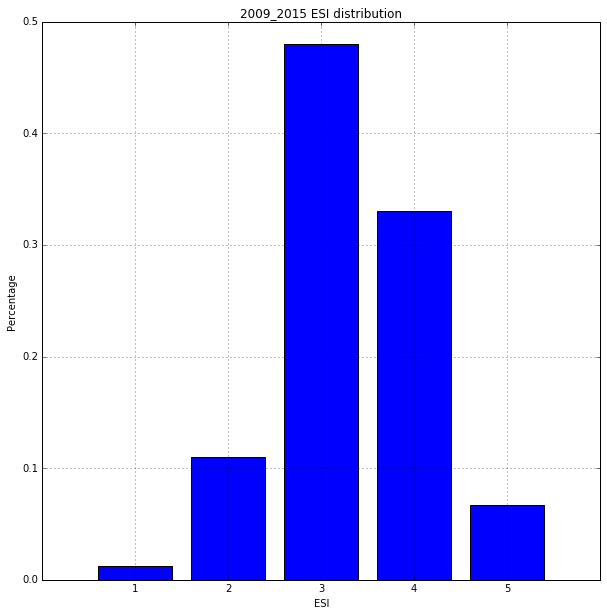

In [8]:
indexes = range(len(sei_distribution))
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
ax.bar(indexes, list(sei_distribution ['pct']),  align='center', color='blue', ecolor='black')
ax.set_xticks(indexes)
ax.set_xticklabels(sei_distribution ['IMMEDR'])
ax.grid(True)
ax.set_xlabel('ESI')
ax.set_ylabel('Percentage')
ax.set_title( year + ' ESI distribution')
plt.show()
fig.savefig('../../reports/figures/graphs/ESI_distribution_' + year + '.png')

### Critical Outcome Distribution

In [16]:
def get_critical_outcome (x):
    if x['DIEDED'] == 1 or x['HDSTAT'] == 2:
        return 'Mortality'
    elif x['ADMIT'] == 1 or x['ADMIT'] == 2:
        return 'ICU'
    elif x['ADMIT']== 3 or x['ADMIT']== 5:
        return'OR_CATH'
    else:
        return 'None'

In [17]:
cdc_input['Critical_Outcome'] = cdc_input.apply(get_critical_outcome, axis=1)

In [18]:
critical_outcome_distribution = cdc_input.groupby(['Critical_Outcome']).size().reset_index(name='counts')
critical_outcome_distribution ['pct'] = critical_outcome_distribution ['counts'] / len(cdc_input)
critical_outcome_distribution =critical_outcome_distribution.sort_values('pct')
critical_outcome_distribution

,Critical_Outcome,counts,pct
1,Mortality,554,0.004408
3,OR_CATH,1097,0.008728
0,ICU,4351,0.034617
2,None,119689,0.952248


In [19]:
def plot_co():
    indexes = range(len(critical_outcome_distribution))

    fig,ax = plt.subplots(1, 1, figsize=(10, 10))
    colors = ['red', 'purple', 'orange', 'gray']
    ax.bar(indexes, list(critical_outcome_distribution ['pct']),  align='center', color=colors)
    ax.set_xticks(indexes)
    ax.set_xticklabels(critical_outcome_distribution ['Critical_Outcome'])
    ax.grid(True)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_xlabel('Critical_Outcome')
    ax.set_ylabel('Percentage')
    ax.set_title( year +' Critical_Outcome distribution')
    return fig, ax

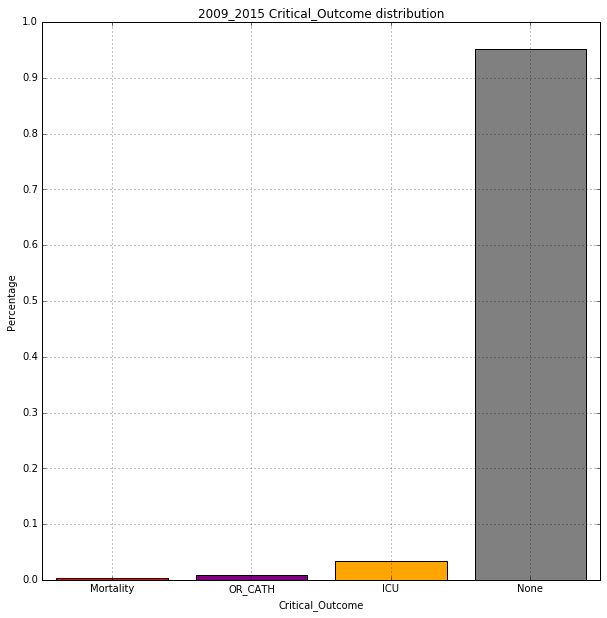

In [20]:
fig, ax =plot_co()
plt.show()
fig.savefig('../../reports/figures/graphs/Critical_Outcome_distribution_' + year + '.png')

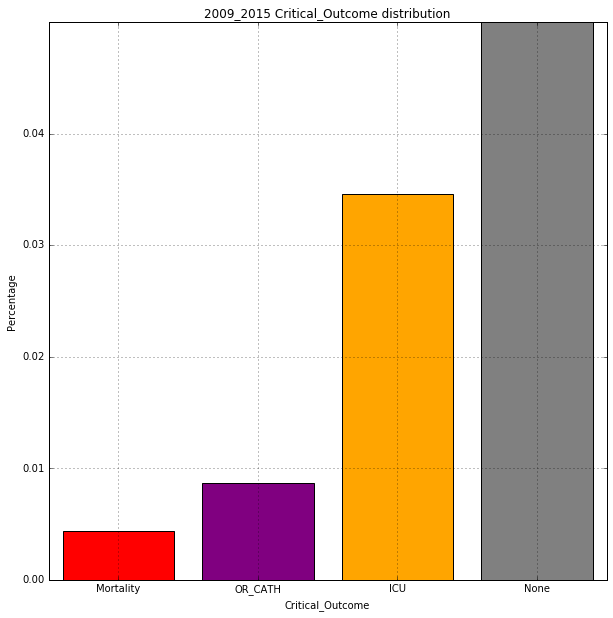

In [21]:
fig, ax = plot_co()
ax.set_ylim(0,0.05) 
ax.set_yticks(np.arange(0.0, 0.05, 0.01))
plt.show()
fig.savefig('../../reports/figures/graphs/Critical_Outcome_distribution_Zoom_' + year + '.png')

### Critical Outcome by ESI Distribution


In [22]:
def fill_zero_size(totals,ESI_list):
    list = []
    for esi in ESI_list:
        if (totals["IMMEDR"] == esi).any() :
            list.append(totals[totals["IMMEDR"] == esi]['pct'].values[0])
        else:
            list.append(0)
    return list

In [23]:
def plot_co_esi(year, type, Mortality_pct, or_cath_pct, ICU_pct, None_pct):
    ind = range(len(sei_distribution))
    width = 0.5       # the width of the bars: can also be len(x) sequence
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(7,7)
    #mortality
    mortality_list = fill_zero_size(Mortality_pct,sei_distribution["IMMEDR"])
    mortality = plt.bar(ind, mortality_list, width, color='red',align='center')
    b =mortality_list
    #or_cath
    or_cath_list = fill_zero_size(or_cath_pct,sei_distribution["IMMEDR"])
    or_cath = plt.bar(ind, or_cath_list, width, color='purple', align='center', bottom= b)
    b = np.array(b) + np.array(or_cath_list)
    #icu
    icu_list= fill_zero_size(ICU_pct,sei_distribution["IMMEDR"])
    icu = plt.bar(ind, icu_list, width, color='orange',  align='center',bottom= b)
    b = np.array(b) + np.array(icu_list)
    #None
    none_list = fill_zero_size(None_pct,sei_distribution["IMMEDR"])
    none  = plt.bar(ind, none_list, width, color='gray', align='center', bottom= b)
    plt.grid(True)
    plt.ylabel('Percentage', fontsize=18)
    plt.xlabel('ESI',fontsize=18)
    plt.title(year + ' ' + type  +' Critical Outcomes by ESI', fontsize=18)
    plt.xticks(ind, sei_distribution ['IMMEDR'], fontsize=16)
    plt.legend((mortality[0], or_cath[0], icu[0], none[0]), ('Mortality', 'OR_CATH', 'ICU', 'None'), fontsize=18)
    return fig, plt

In [24]:
def ESI_CO_distribution_viz (year,  cinput, type = "",zoom=False):
    CO_esi_distribution = cinput.groupby([ 'IMMEDR', 'Critical_Outcome']).size().reset_index(name='counts')
    CO_esi_distribution ['pct'] = CO_esi_distribution ['counts'] / len(cinput)
    print  CO_esi_distribution
    Mortality_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='Mortality']
    or_cath_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='OR_CATH']
    ICU_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='ICU']
    None_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='None']
    fig,plt = plot_co_esi(year, type, Mortality_pct, or_cath_pct, ICU_pct, None_pct)
    name = '../../reports/figures/graphs/Critical_Outcome_ESI_distribution_' + year + type + '.png'
    if zoom:
        plt.ylim(0,0.04) 
        name = '../../reports/figures/graphs/Critical_Outcome_ESI_distribution_Zoomed' + year + type + '.png'
    plt.show()
    fig.savefig(name)
    

    IMMEDR Critical_Outcome  counts       pct
0        1              ICU     227  0.001806
1        1        Mortality     161  0.001281
2        1             None    1163  0.009253
3        1          OR_CATH      36  0.000286
4        2              ICU    1518  0.012077
5        2        Mortality     198  0.001575
6        2             None   11876  0.094486
7        2          OR_CATH     257  0.002045
8        3              ICU    2180  0.017344
9        3        Mortality     152  0.001209
10       3             None   57305  0.455920
11       3          OR_CATH     653  0.005195
12       4              ICU     327  0.002602
13       4        Mortality      23  0.000183
14       4             None   41027  0.326412
15       4          OR_CATH     117  0.000931
16       5              ICU      99  0.000788
17       5        Mortality      20  0.000159
18       5             None    8318  0.066178
19       5          OR_CATH      34  0.000271


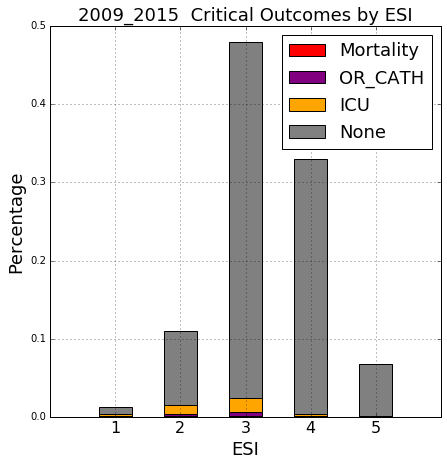

In [25]:
ESI_CO_distribution_viz (year, cdc_input)

    IMMEDR Critical_Outcome  counts       pct
0        1              ICU     227  0.001806
1        1        Mortality     161  0.001281
2        1             None    1163  0.009253
3        1          OR_CATH      36  0.000286
4        2              ICU    1518  0.012077
5        2        Mortality     198  0.001575
6        2             None   11876  0.094486
7        2          OR_CATH     257  0.002045
8        3              ICU    2180  0.017344
9        3        Mortality     152  0.001209
10       3             None   57305  0.455920
11       3          OR_CATH     653  0.005195
12       4              ICU     327  0.002602
13       4        Mortality      23  0.000183
14       4             None   41027  0.326412
15       4          OR_CATH     117  0.000931
16       5              ICU      99  0.000788
17       5        Mortality      20  0.000159
18       5             None    8318  0.066178
19       5          OR_CATH      34  0.000271


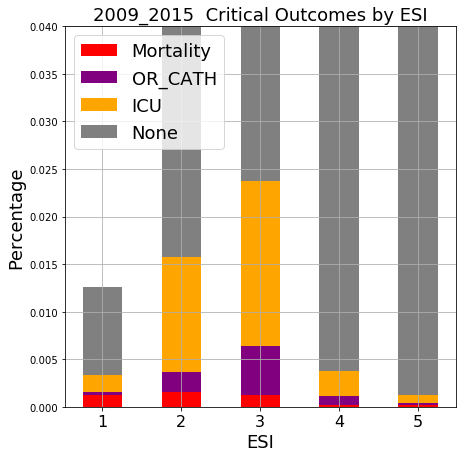

In [23]:
ESI_CO_distribution_viz (year, cdc_input, zoom=True)

In [19]:

pd.options.mode.chained_assignment = None  # default='warn'

In [20]:
def critical_outcome_binary (x):
    if x['DIEDED'] == 1 or x['HDSTAT'] == 2 or x['ADMIT'] == 1 or x['ADMIT']== 3 or x['ADMIT']== 5:
        return 1
    else:
        return 0
def ESI_co_prediction (x):
    if x['IMMEDR'] == 1 or x['IMMEDR'] == 2 :
        return 1
    else:
        return 0    
cdc_input['CO_Flag'] = cdc_input.apply(critical_outcome_binary, axis=1)
cdc_input['SEI_pred_CO']  = cdc_input.apply(ESI_co_prediction, axis=1)

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(cdc_input['CO_Flag'],cdc_input['SEI_pred_CO'] , pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)        
print 'ROC_AUC = %1.3f ' %( roc_auc)

ROC_AUC = 0.660 


In [22]:
#roc_auc_score(cdc_input['CO_Flag'], cdc_input['SEI_pred_CO'], average = 'weighted')

# MSA   
1 = MSA 
2 = Non-MSA

In [23]:
cdc_msa = cdc_input[cdc_input['MSA'] ==1]
cdc_non_msa = cdc_input[cdc_input['MSA'] ==2]

    IMMEDR Critical_Outcome  counts       pct
0        1              ICU     150  0.001604
1        1        Mortality     128  0.001368
2        1             None     825  0.008820
3        1          OR_CATH      28  0.000299
4        2              ICU     627  0.006703
5        2        Mortality     165  0.001764
6        2             None    9766  0.104402
7        2          OR_CATH     230  0.002459
8        3              ICU     722  0.007718
9        3        Mortality     113  0.001208
10       3             None   43898  0.469287
11       3          OR_CATH     541  0.005783
12       4              ICU     106  0.001133
13       4        Mortality      11  0.000118
14       4             None   30113  0.321920
15       4          OR_CATH      92  0.000984
16       5              ICU      49  0.000524
17       5        Mortality      15  0.000160
18       5             None    5939  0.063490
19       5          OR_CATH      24  0.000257


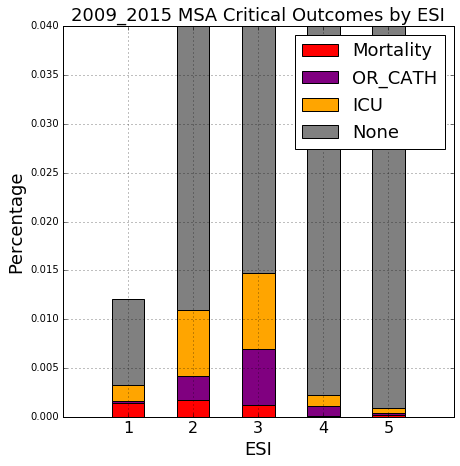

In [24]:
ESI_CO_distribution_viz (year, cdc_msa, type = "MSA" , zoom=True)

    IMMEDR Critical_Outcome  counts       pct
0        1              ICU      16  0.001025
1        1        Mortality      14  0.000897
2        1             None     199  0.012747
3        2              ICU      67  0.004292
4        2        Mortality      16  0.001025
5        2             None    1287  0.082437
6        2          OR_CATH       1  0.000064
7        3              ICU     114  0.007302
8        3        Mortality      13  0.000833
9        3             None    6462  0.413912
10       3          OR_CATH      31  0.001986
11       4              ICU      24  0.001537
12       4        Mortality       7  0.000448
13       4             None    5929  0.379772
14       4          OR_CATH       7  0.000448
15       5              ICU       3  0.000192
16       5        Mortality       2  0.000128
17       5             None    1416  0.090699
18       5          OR_CATH       4  0.000256


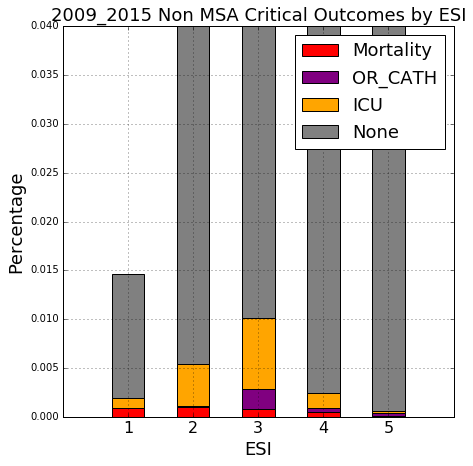

In [25]:
ESI_CO_distribution_viz (year, cdc_non_msa, type = "Non MSA" , zoom=True)

## ESI by Critical Outcomes Distribution

In [95]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%1.2f' % height,
                ha='center', va='bottom', fontsize = 10)


In [90]:
def  plot_bar_chart(year, typeTitle, color, indexes, co, ax, axis_label=True):
    co_list = fill_zero_size(co,sei_distribution["IMMEDR"])
    bars = ax.bar(indexes, co_list,  align='center', color=color, ecolor='black')
    patterns = (' ', ' ', 'x', 'x', 'x')
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xticks(indexes)
    ax.set_xticklabels(sei_distribution ['IMMEDR'])
    ax.grid(True)    
    if axis_label:
        ax.set_xlabel('ESI', fontsize=14)
        ax.set_ylabel('Percentage', fontsize=14)
    #ax.set_title( year + " " + typeTitle + ' ', fontsize=18)
    ax.set_title(  typeTitle , fontsize=14)
    ax.set_ylim(0,0.8)
    autolabel(bars,ax)

In [91]:
def plot_co_and_its_esi(year, typeTitle, Mortality_pct, or_cath_pct, ICU_pct, None_pct):
    indexes = range(len(sei_distribution))
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(9, 3))
    ax0, ax1, ax2 = axes.flatten()
    typeTitleName = typeTitle + ' Mortality'
    plot_bar_chart(year, typeTitleName, 'red', indexes, Mortality_pct, ax0)
    typeTitleName = typeTitle + ' ICU'
    plot_bar_chart(year, typeTitleName, 'orange', indexes, ICU_pct, ax1, axis_label=False)
    typeTitleName = typeTitle + ' OR_CATH'
    plot_bar_chart(year, typeTitleName, 'purple', indexes, or_cath_pct, ax2, axis_label=False)
    #typeTitleName = typeTitle + ' None'
    #plot_bar_chart(year, typeTitleName, indexes, None_pct, ax3)
    #fig.tight_layout()
    plt.show()
    name = '../../reports/figures/graphs/Critical_Outcome_by_ESI_distribution_' + year + typeTitle + '.png'
    plt.show()
    fig.savefig(name)

    
    

In [92]:
def CO_ESI_distribution_viz (year,  cinput,  typeTitle = "",zoom=False):    
    CO_esi_distribution = cinput.groupby([  'Critical_Outcome', 'IMMEDR']).size().reset_index(name='counts')    
    #print  CO_esi_distribution
    Mortality_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='Mortality']
    total_mortality =  Mortality_pct ['counts'].sum()
    Mortality_pct ['pct'] = Mortality_pct ['counts'] / total_mortality
    #print Mortality_pct
    or_cath_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='OR_CATH']
    total_or_cath =  or_cath_pct ['counts'].sum()
    or_cath_pct ['pct'] = or_cath_pct ['counts'] / total_or_cath
    #print  or_cath_pct
    ICU_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='ICU']
    total_ICU =  ICU_pct ['counts'].sum()
    ICU_pct ['pct'] = ICU_pct ['counts'] / total_ICU
    None_pct = CO_esi_distribution[CO_esi_distribution['Critical_Outcome'] =='None']
    total_None =  None_pct ['counts'].sum()
    None_pct ['pct'] = None_pct ['counts'] / total_None
    plot_co_and_its_esi(year, typeTitle, Mortality_pct, or_cath_pct, ICU_pct, None_pct)
    

In [93]:
pd.options.mode.chained_assignment = None  # default='warn'

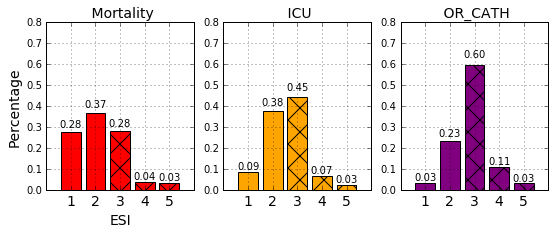

In [96]:
CO_ESI_distribution_viz (year,  cdc_input)

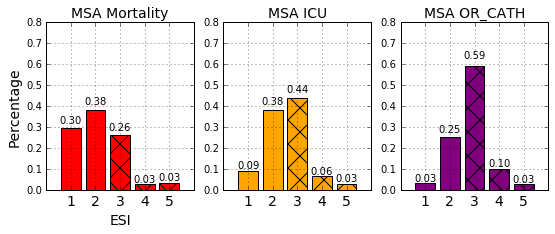

In [97]:
CO_ESI_distribution_viz (year,  cdc_msa,  typeTitle = "MSA")

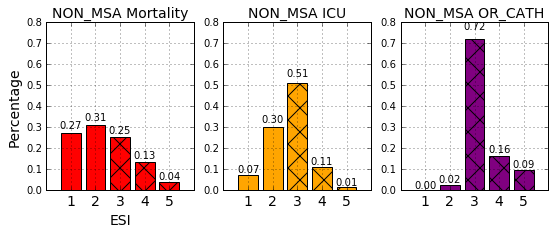

In [98]:
CO_ESI_distribution_viz (year,  cdc_non_msa, typeTitle = "NON_MSA")